# Solving Differential Equation using Physics Informed neural Network
# Differential Equation: d²u/dt² + ω²u = 0
# Initial Conditions: u(0) = 1, du/dt(0) = 0
# Analytical Solution: u(t) = cos(ωt)


# Import required libraries


In [46]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

In [47]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# Neural Network Architecture


In [48]:
net = nn.Sequential(
    nn.Linear(1, 50),
    nn.Tanh(),
    nn.Linear(50, 50),
    nn.Tanh(),
    nn.Linear(50, 50),
    nn.Tanh(),
    nn.Linear(50, 1)
).to(device)

# Problem Setup: Harmonic Oscillator
# Differential Equation: d²u/dt² + ω²u = 0
# Initial Conditions: u(0) = 1, du/dt(0) = 0
# Analytical Solution: u(t) = cos(ωt)
omega = 2.0  # Angular frequency

# Training parameters
learning_rate = 0.001
epochs = 10000
n_points = 100
t_domain = [0, 2*np.pi]

# Generate training points


In [49]:
t_train = torch.linspace(t_domain[0], t_domain[1], n_points).reshape(-1, 1).to(device)
t_train.requires_grad_(True)


tensor([[0.0000],
        [0.0635],
        [0.1269],
        [0.1904],
        [0.2539],
        [0.3173],
        [0.3808],
        [0.4443],
        [0.5077],
        [0.5712],
        [0.6347],
        [0.6981],
        [0.7616],
        [0.8251],
        [0.8885],
        [0.9520],
        [1.0155],
        [1.0789],
        [1.1424],
        [1.2059],
        [1.2693],
        [1.3328],
        [1.3963],
        [1.4597],
        [1.5232],
        [1.5867],
        [1.6501],
        [1.7136],
        [1.7771],
        [1.8405],
        [1.9040],
        [1.9675],
        [2.0309],
        [2.0944],
        [2.1579],
        [2.2213],
        [2.2848],
        [2.3483],
        [2.4117],
        [2.4752],
        [2.5387],
        [2.6021],
        [2.6656],
        [2.7291],
        [2.7925],
        [2.8560],
        [2.9195],
        [2.9829],
        [3.0464],
        [3.1099],
        [3.1733],
        [3.2368],
        [3.3003],
        [3.3637],
        [3.4272],
        [3

# Optimizer


In [50]:
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


# Loss function components


In [51]:
def physics_loss(t):
    u = net(t)

    # First derivative
    u_t = grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Second derivative
    u_tt = grad(u_t, t, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]

    # Physics equation: d²u/dt² + ω²u = 0
    physics_residual = u_tt + omega**2 * u

    return torch.mean(physics_residual**2)

def boundary_loss():
    t_0 = torch.tensor([[0.0]], requires_grad=True).to(device)

    # Initial condition: u(0) = 1
    u_0 = net(t_0)
    ic1_loss = (u_0 - 1.0)**2

    # Initial condition: du/dt(0) = 0
    u_t_0 = grad(net(t_0), t_0, grad_outputs=torch.ones_like(net(t_0)), create_graph=True)[0]
    ic2_loss = u_t_0**2

    return ic1_loss + ic2_loss

# Training loop
losses = []
physics_losses = []
boundary_losses = []

# training Modal

In [52]:
print("Starting training...")
for epoch in range(epochs):
    optimizer.zero_grad()

    # Calculate losses
    phys_loss = physics_loss(t_train)
    bound_loss = boundary_loss()

    # Total loss
    total_loss = phys_loss + 10 * bound_loss  # Weight boundary conditions more heavily

    total_loss.backward()
    optimizer.step()

    # Store losses for plotting
    losses.append(total_loss.item())
    physics_losses.append(phys_loss.item())
    boundary_losses.append(bound_loss.item())

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Total Loss: {total_loss.item():.6f}, Physics Loss: {phys_loss.item():.6f}, Boundary Loss: {bound_loss.item():.6f}')

print("Training completed!")

Starting training...
Epoch 0, Total Loss: 10.603054, Physics Loss: 0.093639, Boundary Loss: 1.050941
Epoch 1000, Total Loss: 0.298213, Physics Loss: 0.289044, Boundary Loss: 0.000917
Epoch 2000, Total Loss: 0.178585, Physics Loss: 0.174923, Boundary Loss: 0.000366
Epoch 3000, Total Loss: 0.157740, Physics Loss: 0.156239, Boundary Loss: 0.000150
Epoch 4000, Total Loss: 0.137221, Physics Loss: 0.135094, Boundary Loss: 0.000213
Epoch 5000, Total Loss: 0.044475, Physics Loss: 0.043959, Boundary Loss: 0.000052
Epoch 6000, Total Loss: 0.002017, Physics Loss: 0.002016, Boundary Loss: 0.000000
Epoch 7000, Total Loss: 0.016719, Physics Loss: 0.013729, Boundary Loss: 0.000299
Epoch 8000, Total Loss: 0.000456, Physics Loss: 0.000454, Boundary Loss: 0.000000
Epoch 9000, Total Loss: 0.000333, Physics Loss: 0.000333, Boundary Loss: 0.000000
Training completed!


# Generate test data for evaluation


In [53]:
t_test = torch.linspace(t_domain[0], t_domain[1], 200).reshape(-1, 1).to(device)

# Get PINN predictions


In [54]:
with torch.no_grad():
    u_pred = net(t_test).detach().cpu().numpy()

# Analytical solution


In [55]:
t_analytical = t_test.detach().cpu().numpy()
u_analytical = np.cos(omega * t_analytical)

# Calculating error metrics


In [59]:
mse = np.mean((u_pred - u_analytical)**2)
mae = np.mean(np.abs(u_pred - u_analytical))
max_error = np.max(np.abs(u_pred - u_analytical))

print(f"\nError Metrics:")
print(f"Mean Squared Error: {mse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")
print(f"Maximum Error: {max_error:.6f}")



Error Metrics:
Mean Squared Error: 0.000004
Mean Absolute Error: 0.001533
Maximum Error: 0.003956


# Visualisation and comparision

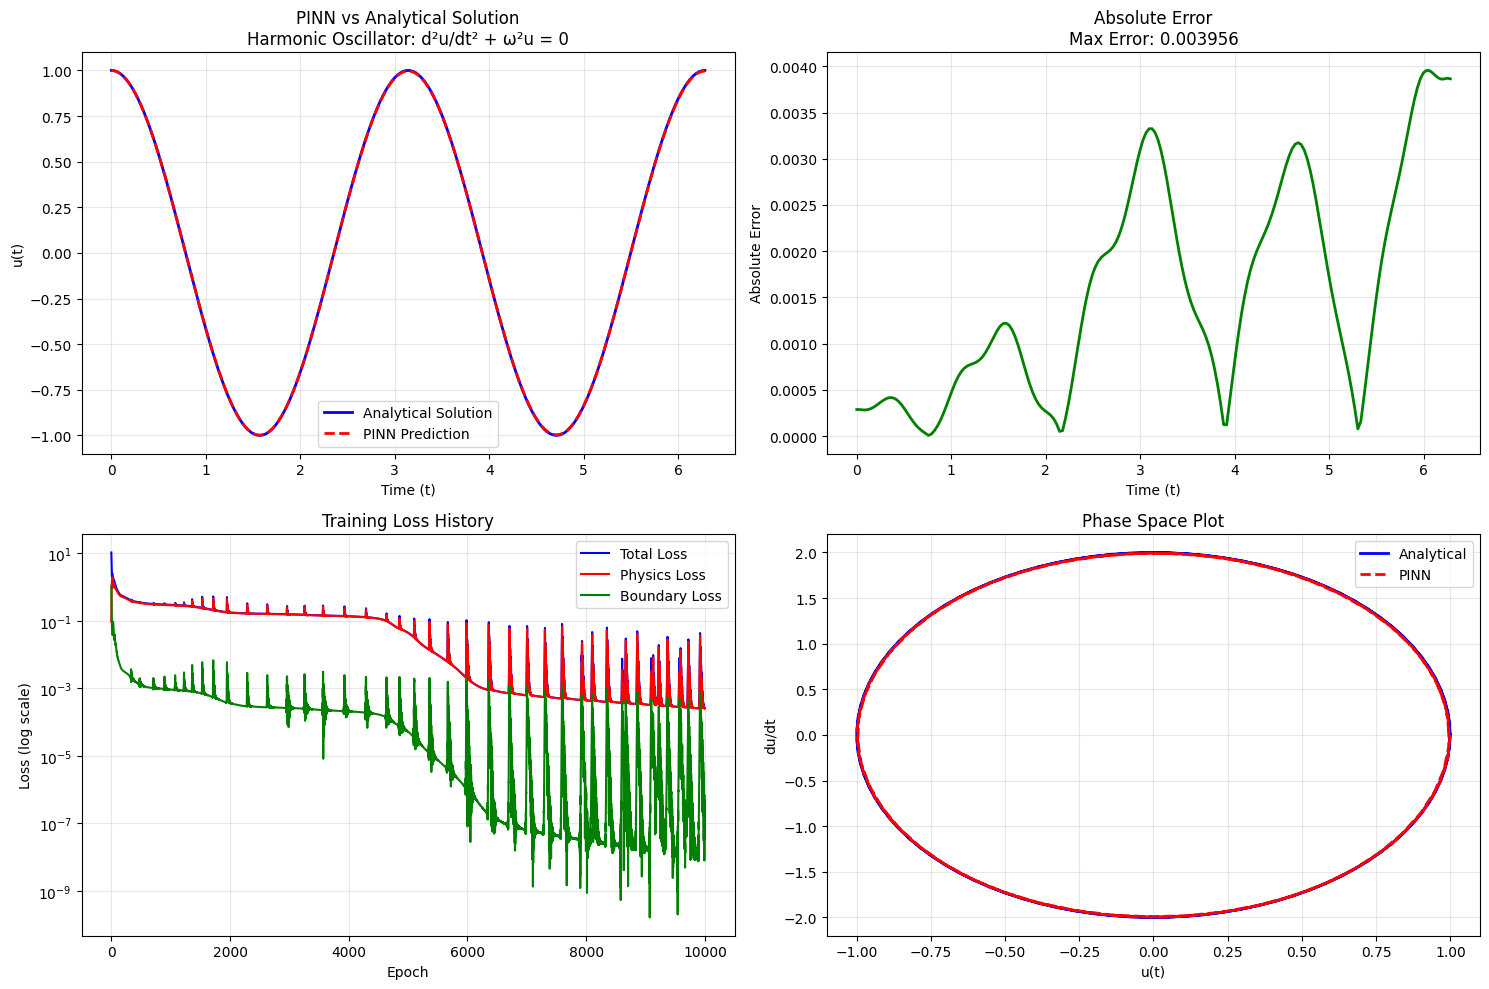


Problem Details:
Differential Equation: d²u/dt² + 2.0²u = 0
Initial Conditions: u(0) = 1, du/dt(0) = 0
Analytical Solution: u(t) = cos(2.0t)
Domain: t ∈ [0, 6.283185307179586]
Training Points: 100
Neural Network: 4 layers (50-50-50 hidden units) with Tanh activation


In [58]:

# Plotting results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Solution comparison
ax1.plot(t_analytical, u_analytical, 'b-', label='Analytical Solution', linewidth=2)
ax1.plot(t_analytical, u_pred, 'r--', label='PINN Prediction', linewidth=2)
ax1.set_xlabel('Time (t)')
ax1.set_ylabel('u(t)')
ax1.set_title('PINN vs Analytical Solution\nHarmonic Oscillator: d²u/dt² + ω²u = 0')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Error plot
error = np.abs(u_pred - u_analytical)
ax2.plot(t_analytical, error, 'g-', linewidth=2)
ax2.set_xlabel('Time (t)')
ax2.set_ylabel('Absolute Error')
ax2.set_title(f'Absolute Error\nMax Error: {max_error:.6f}')
ax2.grid(True, alpha=0.3)

# Plot 3: Training loss
ax3.semilogy(losses, 'b-', label='Total Loss')
ax3.semilogy(physics_losses, 'r-', label='Physics Loss')
ax3.semilogy(boundary_losses, 'g-', label='Boundary Loss')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss (log scale)')
ax3.set_title('Training Loss History')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Phase space (u vs du/dt)
t_phase = torch.linspace(0, 2*np.pi, 100).reshape(-1, 1).to(device)
t_phase.requires_grad_(True)

# Compute u and its derivative (without no_grad context)
u_phase = net(t_phase)
u_t_phase = grad(u_phase, t_phase, grad_outputs=torch.ones_like(u_phase), create_graph=True)[0]

u_phase_np = u_phase.detach().cpu().numpy()
u_t_phase_np = u_t_phase.detach().cpu().numpy()

# Analytical phase space
u_analytical_phase = np.cos(omega * t_phase.detach().cpu().numpy())
u_t_analytical_phase = -omega * np.sin(omega * t_phase.detach().cpu().numpy())

ax4.plot(u_analytical_phase, u_t_analytical_phase, 'b-', label='Analytical', linewidth=2)
ax4.plot(u_phase_np, u_t_phase_np, 'r--', label='PINN', linewidth=2)
ax4.set_xlabel('u(t)')
ax4.set_ylabel('du/dt')
ax4.set_title('Phase Space Plot')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Residual check
print(f"\nProblem Details:")
print(f"Differential Equation: d²u/dt² + {omega}²u = 0")
print(f"Initial Conditions: u(0) = 1, du/dt(0) = 0")
print(f"Analytical Solution: u(t) = cos({omega}t)")
print(f"Domain: t ∈ [{t_domain[0]}, {t_domain[1]}]")
print(f"Training Points: {n_points}")
print(f"Neural Network: 4 layers (50-50-50 hidden units) with Tanh activation")

# Test physics equation satisfaction
t_test_residual = torch.linspace(0, 2*np.pi, 50).reshape(-1, 1).to(device)
t_test_residual.requires_grad_(True)

u_test = net(t_test_residual)
u_t_test = grad(u_test, t_test_residual, grad_outputs=torch.ones_like(u_test), create_graph=True)[0]
u_tt_test = grad(u_t_test, t_test_residual, grad_outputs=torch.ones_like(u_t_test), create_graph=True)[0]

residual = u_tt_test + omega**2 * u_test
residual_rms = torch.sqrt(torch.mean(residual**2)).detach().item()


# Physics Equation Satisfaction

In [57]:
print(f"\nPhysics Equation Satisfaction:")
print(f"RMS Residual of d²u/dt² + ω²u: {residual_rms:.8f}")
print(f"(Should be close to 0 for perfect solution)")


Physics Equation Satisfaction:
RMS Residual of d²u/dt² + ω²u: 0.01642787
(Should be close to 0 for perfect solution)
